<h1>Chapter 03. Classification</h1>

<h2>MNIST</h2>

This chapter uses the Mixed National Institute of Standards and Technology (MNIST) dataset, which contains 70,000 small images of numbers handwritten by high school students and U.S. Census Bureau employees. Each image is labeled with the digit it represents.

In [1]:
from sklearn.datasets import fetch_openml


mnist = fetch_openml(
    'mnist_784',
    version=1,
    as_frame=False,  # to avoid DataFrame use as_frame=False
    parser='auto'
)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']

In [3]:
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

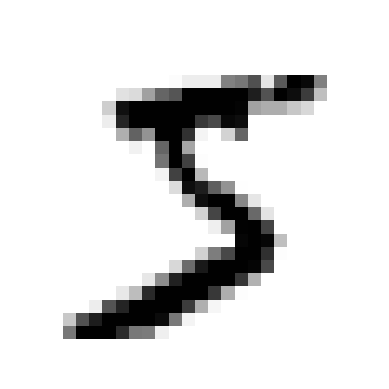

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt


some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(
    some_digit_image,
    cmap=mpl.cm.binary,
    interpolation='nearest',
)
plt.axis('off')
plt.show()

In [6]:
# Check some_digit target
y[0]

'5'

In [7]:
import numpy as np

# Convert the y data type to unsigned 8-bit integers (uint8).
y = y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imsow(
        image,
        cmap=mpl.cm.binary,
        interpolation='nearest',
    )
    plt.axis('off')

In [9]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). First need to move the axes to combine
    # next to each other, using transpose(), and only then reshape
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Show a big_image
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

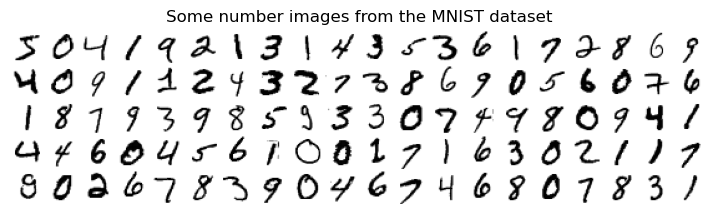

In [10]:
plt.figure(figsize=(9, 9))

example_impages = X[:100]
plot_digits(example_impages, images_per_row=20)

plt.title('Some number images from the MNIST dataset')
plt.show()

In [11]:
# Check tagret by index
y[4]

9

The MNIST dataset is already divided into a training set (first 60000 images) and a test set (last 10000 images)

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 

<h2>Training a Binary Classifier</h2>

In [13]:
y_train_5 = (y_train == 5)  # True for all 5 numbers, False for others
y_test_5 = (y_test == 5)

`SGDClassifier`: A fast and adaptable linear classifier for classification tasks.

In [14]:
from sklearn.linear_model import SGDClassifier


sgd_clf = SGDClassifier(
    max_iter=1000,  # max number of training iterations
    tol=1e-3,  # tolerane for stopping criteria
    random_state=42  # random seed for reproducibility
)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
# Check classifier
sgd_clf.predict([some_digit])

array([ True])

Perform k-fold cross-validation on the `SGDClassifier` model using accuracy as the scoring metric.

In [16]:
from sklearn.model_selection import cross_val_score


cross_val_score(
    sgd_clf,
    X_train,
    y_train_5,
    scoring='accuracy',
    cv=3
)

array([0.95035, 0.96035, 0.9604 ])

<h2>Perfomance Measures</h2>

<h3>Measuring Accuracy using Cros-Validation</h3>

Create a cross-check on your own that does roughly the same as the `cross_val_score()`

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone


skfolds = StratifiedKFold(
    n_splits=3,  # number of splits (folds)
    random_state=42,
    shuffle=True  # shuffle the data before splitting
)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]

    X_test_folds = X_train[test_index]
    y_test_folds = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)

    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


Create a classifier which simply categorizes all images as "not 5" class

In [18]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
never_5_clf = Never5Classifier()

cross_val_score(
    never_5_clf,
    X_train,
    y_train_5,
    scoring='accuracy',
    cv=3
)

array([0.91125, 0.90855, 0.90915])

<h3>Confusion Matrix</h3>

The `confusion_matrix` function evaluates classification accuracy by computing the confusion matrix with each row corresponding to the true class.

In [20]:
from sklearn.model_selection import cross_val_predict


y_train_pred = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3
)

In [21]:
from sklearn.metrics import confusion_matrix


confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In the first row, 53892 images of non-fives were correctly classified, but 687 were wrongly predicted as fives. In the second row, 1891 were wrongly predicted as non-fives, but 3530 images of fives were correctly classified.

In [22]:
y_train_perfest_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfest_predictions)

array([[54579,     0],
       [    0,  5421]])

<h3>Precision and Recall</h3>

`precision_score` measures the accuracy of positive class predictions, while `recall_score` quantifies the true positive rate of a classifier.

In [23]:
from sklearn.metrics import precision_score, recall_score


precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [24]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

F1 score is the harmonic mean of precision and recall, offering a single metric to balance both.

In [25]:
from sklearn.metrics import f1_score


f1_score(y_train_5, y_train_pred)

0.7325171197343846

<h3>Precision/Recall Trade-off</h3>

`SGDClassifier.decision_function` returns the raw decision scores for each instance, which can be used to make predictions based on customizable decision thresholds.

In [26]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    method='decision_function',
    cv=3
)

`precision_recall_curve()` computes precision and recall values for different probability thresholds.

In [30]:
from sklearn.metrics import precision_recall_curve


precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Plot precision and recall as functions of the threshold value.

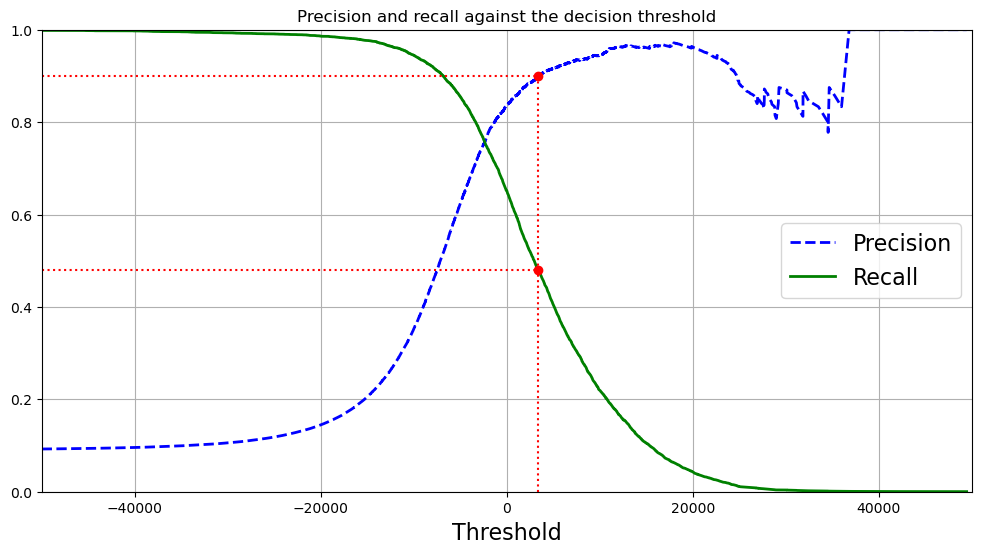

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(
        thresholds,
        precisions[:-1],
        'b--',
        label='Precision',
        linewidth=2
    )
    plt.plot(
        thresholds,
        recalls[:-1],
        'g-',
        label='Recall',
        linewidth=2
    )
    plt.legend(loc='center right', fontsize=16)
    plt.xlabel('Threshold', fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

# Calculate the recall at 90% precision
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
# Find the threshold corresponding to 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(12, 6))
plot_precision_recall_vs_threshold(precisions=precisions, recalls=recalls, thresholds=thresholds)
# Add a vertical dashed line at the threshold where precision reaches 90%
plt.plot(
    [threshold_90_precision, threshold_90_precision],  # X-coordinate: repeats the threshold value
    [0., 0.9],  # Y-coordinate: starts at 0 and goes up to 0.9
    'r:'
)

# Add a horizontal dashed line at the precision level of 0.9 (90%)
plt.plot(
    [-50000, threshold_90_precision],  # X-coordinate: starts from -50000 and goes to the threshold value
    [0.9, 0.9],  # Y-coordinate: repeats the precision level of 0.9
    'r:'
)

# Add another horizontal dashed line at the recall level where precision reaches 90%
plt.plot(
    [-50000, threshold_90_precision],  # X-coordinate: starts from -50000 and goes to the threshold value
    [recall_90_precision, recall_90_precision],  # y-coordinate: Repeats the recall level at this threshold
    'r:'
)

# Mark the threshold point where precision reaches 90%
plt.plot(
    [threshold_90_precision],  # X-coordinate: the threshold where precision reaches 90%
    [0.9],  # Y-coordinate: the precision level of 0.9
    'ro'
)

# Mark the threshold point where recall is at the level where precision reaches 90%
plt.plot(
    [threshold_90_precision],  # X-coordinate: the threshold where precision reaches 90%
    [recall_90_precision],  # Y-coordinate: the corresponding recall level at this threshold
    'ro'
)
plt.title('Precision and recall against the decision threshold')
plt.show()

Plot precision in comparison with recall

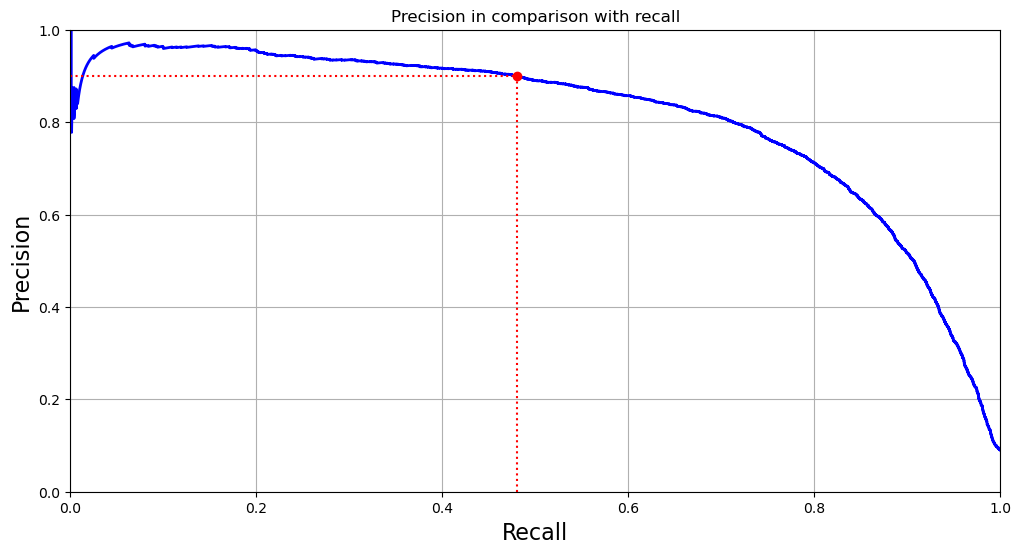

In [32]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(
        recalls,
        precisions,
        'b-',
        linewidth=2
    )
    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(12, 6))
plot_precision_vs_recall(precisions=precisions, recalls=recalls)
plt.plot(
    [recall_90_precision, recall_90_precision],
    [0., 0.9],
    'r:'
)
plt.plot(
    [0.0, recall_90_precision],
    [0.9, 0.9],
    'r:'
)
plt.plot(
    [recall_90_precision],
    [0.9],
    'ro'
)
plt.title('Precision in comparison with recall')
plt.show()

In [33]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [34]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

<h3>The ROC Curve</h3>

An ROC (Receiver Operating Characteristic) curve is a graphical representation that illustrates the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) for a binary classification model at various classification thresholds.

In [37]:
from sklearn.metrics import roc_curve

# fpr - false positive rate, tpr - true negative rate
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Plot FPR in comparison with TPR

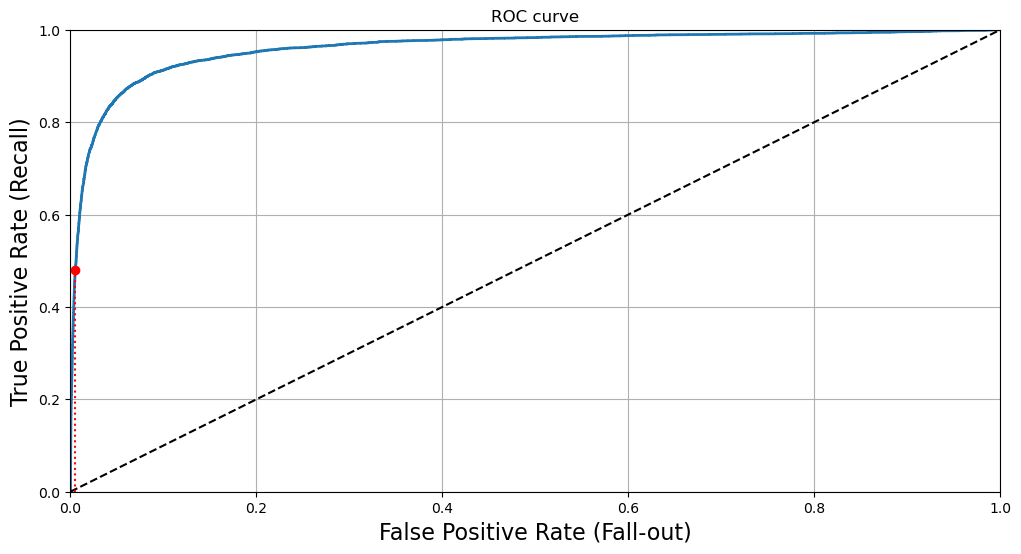

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(
        fpr,
        tpr,
        linewidth=2,
        label=label,
    )
    plt.plot(
        [0, 1],
        [0, 1],
        'k--'  # dashed diagonal
    )
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (Fall-out)', fontsize=16)
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.grid(True)

plt.figure(figsize=(12, 6))
plot_roc_curve(fpr=fpr, tpr=tpr)

fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]

plt.plot(
    [fpr_90, fpr_90],
    [0., recall_90_precision],
    'r:'
)
plt.plot(
    [0.0, fpr_90],
    [recall_90_precision, recall_90_precision],
    'r:'
)
plt.plot(
    [fpr_90],
    [recall_90_precision],
    'ro'
)
plt.title('ROC curve')
plt.show()

The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score is a single numeric value that quantifies the overall performance of a binary classification model by measuring the area under its ROC curve, with a higher score indicating better model discrimination.

In [39]:
from sklearn.metrics import roc_auc_score


roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [40]:
from sklearn.ensemble import RandomForestClassifier


forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=3,
    method='predict_proba'
)

In [41]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

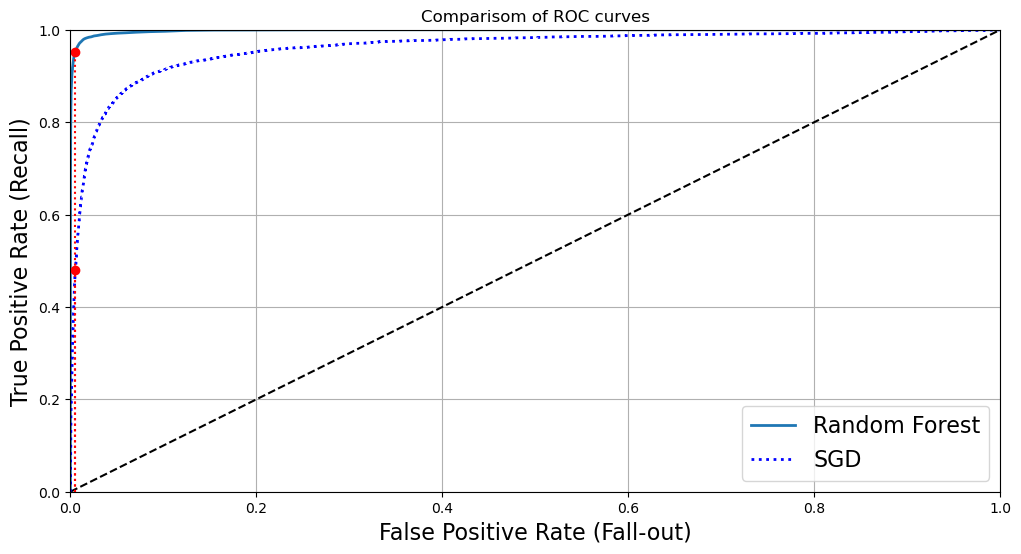

In [42]:
recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(12, 6))
plot_roc_curve(fpr=fpr_forest, tpr=tpr_forest, label='Random Forest')

plt.plot(
    fpr,
    tpr,
    'b:',
    linewidth=2,
    label='SGD',
)
plt.plot(
    [fpr_90, fpr_90],
    [0., recall_90_precision],
    'r:'
)
plt.plot(
    [0.0, fpr_90],
    [recall_90_precision, recall_90_precision],
    'r:'
)
plt.plot(
    [fpr_90],
    [recall_90_precision],
    'ro'
)
plt.plot(
    [fpr_90, fpr_90],
    [0., recall_for_forest],
    'r:'
)
plt.plot(
    [fpr_90],
    [recall_for_forest],
    'ro'
)
plt.grid(True)
plt.legend(loc='lower right', fontsize=16)
plt.title('Comparison of ROC curves')
plt.show()

In [43]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [44]:
y_train_pred_forest = cross_val_predict(
    forest_clf,
    X_train,
    y_train_5,
    cv=3
)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [45]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

<h2>Multiclass Classification</h2>

The `SVC` (Support Vector Classification) class is used for training a Support Vector Machine (SVM) model for binary or multiclass classification tasks, aiming to find a decision boundary that maximizes the margin between different classes in the feature space.

In [47]:
from sklearn.svm import SVC


svm_clf = SVC(gamma='auto', random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000])  # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [48]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [49]:
np.argmax(some_digit_scores)

5

In [50]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [51]:
svm_clf.classes_[5]

5

The `OneVsRestClassifier` is a meta-estimator used for extending binary classification models to multiclass classification problems by training multiple binary classifiers, one for each class, and assigning the class with the highest confidence score as the predicted output.

In [52]:
from sklearn.multiclass import OneVsOneClassifier

_
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train[:1000], y_train[:1000])
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [53]:
len(ovo_clf.estimators_)  # number of binary classifiers created

45

Train `RandomForestClassifier`

In [55]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [56]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [57]:
cross_val_score(
    sgd_clf,
    X_train,
    y_train,
    cv=3,
    scoring='accuracy',
)

array([0.87365, 0.85835, 0.8689 ])

The `StandardScaler` is a preprocessing technique that standardizes the features of a dataset, transforming them to have a mean of 0 and a standard deviation of 1.

In [59]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(
    sgd_clf,
    X_train_scaled,
    y_train,
    cv=3,
    scoring='accuracy'
)

array([0.8983, 0.891 , 0.9018])